# Определение уязвимых групп населения

Задача:
* кластеризовать регионы России и определить, какие из них наиболее
остро нуждаются в помощи малообеспеченным/неблагополучным
слоям населения;
* описать группы населения, сталкивающиеся с бедностью;
* определить:
    * влияет ли число детей, пенсионеров и других социально уязвимых
групп на уровень бедности в регионе;
    * связаны ли уровень бедности/социального неблагополучия с
производством и потреблением в регионе;
    * какие ещё зависимости можно наблюдать относительно
социально незащищённых слоёв населения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from sklearn import cluster, metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.mixture import GaussianMixture
from statsmodels.stats.proportion import proportions_chisquare

## 0. Функция для обработки названий регионов

Для начала работы загрузим список субъектов РФ с сайта [Wikipedia](https://ru.wikipedia.org/wiki/Коды_субъектов_Российской_Федерации) и преобразуем их словарь.

In [2]:
import requests
from bs4 import BeautifulSoup
import re

url = "https://ru.wikipedia.org/wiki/Коды_субъектов_Российской_Федерации"
regions = pd.read_html(requests.get(url).text, match='Наименование субъекта')[0]

regions['Наименование субъекта'] = regions['Наименование субъекта'].str.replace('\xa0', ' ')
regions = regions[regions['Наименование субъекта'] != 'Территории, находящиеся за пределами РФ и обслуживаемые Управлением режимных объектов МВД России, Байконур']
regions =regions.drop(['Код ГИБДД', 'Код ОКАТО и ОКТМО', 'Код ISO 3166-2[1]', 'Код ГОСТ 7.67-2003'], axis=1)

regions_to_delete = ['Ханты-Мансийский автономный округ — Югра', 'Ямало-Ненецкий автономный округ', 'Тюменская область', 'Ненецкий автономный округ', 'Архангельская область', 'Омская область']
cleaned_regions = regions[~regions['Наименование субъекта'].isin(regions_to_delete)]

#функция для создания вспомогательного столбца short
def short_regions(region):
    replace_dict = {'республика':'', 'автономная':'','край':'', 'область':'', 'автономный округ':'','народная':'', 'северная':'', 'автономная область':'', 'эл':'', '(':',', ')':'', ' — ':',',' - ':',',' ':''}
    reg_replace = {'саха': "республика саха", "алтай": "республика алтай", "коми": "республика коми"}
    for old, new in replace_dict.items():
        region = region.lower().replace(old, new)
            
    region = region.split(',')
    
    for key in reg_replace:
        if key in region:
            region.remove(key)
            region.append(reg_replace[key])
    return region

cleaned_regions['short'] = cleaned_regions['Наименование субъекта'].apply(short_regions)

regions_dict = {element: row['Наименование субъекта'] for _, row in cleaned_regions.iterrows() for element in row['short']}

#Добавляем в словарь исключения, которые не удалось обработать функцией change_name
regions_dict.update({'санкт':'Санкт-Петербург', 
                     'bладимирская': 'Владимирская область',
                     'bоронежская':'Воронежская область',
                     'bологодская':'Вологодская область',
                     'bолгоградская область':'Волгоградская область',
                     'тюменская область без автономного округа':'Тюменская область',
                     'тюменская область без\nавтономных округов':'Тюменская область',
                     'юменская обл.без данных по':'Тюменская область',
                     'рхангельская обл. без данных по':'Архангельская область',
                     'юменская область (кроме': 'Тюменская область',
                     'рхангельская область (кроме': 'Архангельская область'})

/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_54341/250713686.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  regions = pd.read_html(requests.get(url).text, match='Наименование субъекта')[0]
/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_54341/250713686.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_regions['short'] = cleaned_regions['Наименование субъекта'].apply(short_regions)


In [3]:
# Функция для преобразования наименований субъектов:

def change_name(name):
    name_lower = name.lower()

    for n, region in regions_dict.items():
        if n in name_lower:
            return region

    #Далее обрабатываем исключения
    
    if re.search(r'\bомская\b(?!.*томская)', name_lower):
        return "Омская область"

    if any(keyword in name_lower for keyword in ['ханты', 'югра']):
        return 'Ханты-Мансийский автономный округ — Югра'
    elif 'ямало' in name_lower:
        return 'Ямало-Ненецкий автономный округ'
    elif 'тюменская' in name_lower:
        return 'Тюменская область'

    if all(keyword in name_lower for keyword in ['ненецкий', 'архангельск']):
        return "Ненецкий автономный округ"
    elif re.search(r'\bненецкий\b', name_lower) and not re.search(r'\bямало-ненецкий\b', name_lower):
        return "Ненецкий автономный округ"
    elif 'архангельск' in name_lower:
        return "Архангельская область"

    print(f"No match found for '{name_lower}'") #Выводим строки, которые не удалось обработать
    return name

## 1. Обработка данных

### 1.1. Подгрузка данных из таблиц

In [4]:
# создадим пустые списки, которые будем наполнять в процессе обработки таблицы, после чего мы сможем 
# использовать эти списки для формирования одного общего набора данных.

tables = []
columns = []

#### 1.1.1 Доходы населения

In [5]:

#Среднедущевые доходы населения

cash_capita = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx')

# Исключим строки содержащие федеральный округ, федерация и район
district = cash_capita[cash_capita['region'].str.contains('федеральный округ|Федерация|район|числе')].index
cash_capita.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
cash_capita['region'] = cash_capita['region'].apply(change_name)

cash_capita.set_index('region', inplace=True)
cash_capita = cash_capita[~cash_capita.index.duplicated(keep='last')]

cash_capita = cash_capita.mean(axis=1)

print('Среднедушевые денежные доходы (в месяц), руб')
cash_capita.head()

Среднедушевые денежные доходы (в месяц), руб


region
Белгородская область    30692.500000
Брянская область        26015.500000
Владимирская область    23908.333333
Воронежская область     30422.833333
Ивановская область      24567.833333
dtype: float64

In [6]:
# Реальные доходы населения

real_incomes = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', 1)

# Исключим строки содержащие федеральный округ, федерация и район
district = real_incomes[real_incomes['region'].str.contains('федеральный округ|Федерация|район|числе')].index
real_incomes.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
real_incomes['region'] = real_incomes['region'].apply(change_name)

real_incomes.set_index('region', inplace=True)
real_incomes = real_incomes[~real_incomes.index.duplicated(keep='last')]

#Заполняем пустые значения нулями, потому что в датасете нет информации о Республике Крым и г. Севатостополь до 2015 года
real_incomes = real_incomes.fillna(0)

# Преобразуем проценты в множители (например, 102% станет 1.02, 98% станет 0.98 и т.д.)
multipliers = real_incomes.iloc[:, 1:] / 100

# Применяем множители последовательно, начиная со 100% в базовом году
cumulative_growth = multipliers.cumprod(axis=1)

# Получаем конечный множитель роста или падения, сравнивая последний год с базовым значением 100%
# Мы отнимаем 1, потому что базовое значение было 100% или 1.0
real_incomes = cumulative_growth.iloc[:, -1] - 1

print('Реальные денежные доходы (в процентах к предыдущему году), %')
real_incomes.head()

Реальные денежные доходы (в процентах к предыдущему году), %


region
Белгородская область   -0.026988
Брянская область       -0.066900
Владимирская область   -0.104430
Воронежская область    -0.120706
Ивановская область     -0.097117
Name: 2020, dtype: float64

In [7]:
# Номинальная заработная плата

formal_wage_paid = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', 2)

# Исключим строки содержащие федеральный округ, федерация и район
district = formal_wage_paid[formal_wage_paid['region'].str.contains('федеральный округ|Федерация|район|числе')].index
formal_wage_paid.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
formal_wage_paid['region'] = formal_wage_paid['region'].apply(change_name)

formal_wage_paid.set_index('region', inplace=True)
formal_wage_paid = formal_wage_paid[~formal_wage_paid.index.duplicated(keep='last')]

formal_wage_paid = formal_wage_paid.mean(axis=1)

print('Номинальная заработная плата (в месяц), руб')
formal_wage_paid.head()

Номинальная заработная плата (в месяц), руб


region
Белгородская область    30920.333333
Брянская область        26399.166667
Владимирская область    29127.166667
Воронежская область     30077.000000
Ивановская область      24856.666667
dtype: float64

In [8]:
# Реальная заработная плата

real_pay = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', 3)

# Исключим строки содержащие федеральный округ, федерация и район
district = real_pay[real_pay['region'].str.contains('федеральный округ|Федерация|район|числе')].index
real_pay.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
real_pay['region'] = real_pay['region'].apply(change_name)

real_pay.set_index('region', inplace=True)
real_pay = real_pay[~real_pay.index.duplicated(keep='last')]

# Преобразуем проценты в множители (например, 102% станет 1.02, 98% станет 0.98 и т.д.)
multipliers = real_pay.iloc[:, 1:] / 100

# Применяем множители последовательно, начиная со 100% в базовом году
cumulative_growth = multipliers.cumprod(axis=1)

# Получаем конечный множитель роста или падения, сравнивая последний год с базовым значением 100%
# Мы отнимаем 1, потому что базовое значение было 100% или 1.0
real_pay = cumulative_growth.iloc[:, -1] - 1

print('Реальная заработная плата (в месяц), руб')
real_pay.head()

Реальная заработная плата (в месяц), руб


region
Белгородская область    0.226147
Брянская область        0.163988
Владимирская область    0.204056
Воронежская область     0.181671
Ивановская область      0.095723
Name: 2020, dtype: float64

In [9]:
# добавляем таблицы в список

for df in [cash_capita, real_incomes, real_pay, formal_wage_paid]:
    tables.append(df)
    
for col in ['cash_capita', 'real_incomes', 'real_pay', 'formal_wage_paid']:
    columns.append(col)

#### 1.1.2. Число умерших на первом году жизни детей за год

In [10]:
# Детская смертность в сельской местности

rural = pd.read_excel('data/child_mortality_rural_1990_2021.xls', skiprows=2)

# Удалим лишние столбцы
rural.drop(['Unnamed: 1', 'Unnamed: 2'], axis = 1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = rural[rural['Unnamed: 0'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|кроме|Коми-Пермяцкий|Таймырский|Эвенкийский|Агинский')].index
# Удаляем пробелы перед названием регионов
rural['Unnamed: 0'] = rural['Unnamed: 0'].str.strip()
rural.drop(district, axis = 0, inplace=True)

rural.rename(columns={'Unnamed: 0':"region"}, inplace=True)

# Унифицируем названия регионов
rural['region'] = rural['region'].apply(change_name)

rural.set_index('region', inplace=True)
rural = rural[~rural.index.duplicated(keep='first')]

In [11]:

# Детская смертность в городской местности

urban = pd.read_excel('data/child_mortality_urban_1990_2021.xls', skiprows=2)

# Удалим лишние столбцы
urban.drop(['Unnamed: 1', 'Unnamed: 2'], axis = 1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = urban[urban['Unnamed: 0'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|кроме|Коми-Пермяцкий|Таймырский|Эвенкийский|Агинский')].index
# Удаляем пробелы перед названием регионов
urban['Unnamed: 0'] = urban['Unnamed: 0'].str.strip()
urban.drop(district, axis = 0, inplace=True)

urban.rename(columns={'Unnamed: 0':"region"}, inplace=True)

# Унифицируем названия регионов
urban['region'] = urban['region'].apply(change_name)

urban.set_index('region', inplace=True)
urban = urban[~urban.index.duplicated(keep='first')]

# Объединяем детскую смертность с городов и регионов
child_mortality = rural.add(urban)
child_mortality = child_mortality.mean(axis=1)

# добавляем таблицы в список
tables.append(child_mortality)
columns.append('child_mortality')

print('Количетсво умерших детей, чел.')
child_mortality.head()

Количетсво умерших детей, чел.


region
Белгородская область    139.21875
Брянская область        154.40625
Владимирская область    142.78125
Воронежская область     216.31250
Ивановская область      116.25000
dtype: float64

#### 1.1.3 Люди с инвалидностью

In [12]:

disabled = pd.read_csv('data/disabled_total_by_age_2017_2022.csv')

# Исключаем строки содержащие федеральный округ, федерация и район
district = disabled[disabled['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
disabled.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
disabled['region'] = disabled['region'].apply(change_name)

disabled.set_index('region', inplace=True)

# Выполняем группировку по году
disabled['date'] = pd.to_datetime(disabled['date']).dt.year
disabled = disabled.groupby(['region','date'])['total'].sum().unstack()
disabled = disabled.mean(axis=1)

# добавляем таблицы в список
tables.append(disabled)
columns.append('disabled')

print('Количество инвалидов, чел.')
disabled.head()

Количество инвалидов, чел.


region
Алтайский край           1.816918e+06
Амурская область         6.893337e+05
Архангельская область    9.065442e+05
Астраханская область     4.636028e+05
Белгородская область     2.155028e+06
dtype: float64

#### 1.1.4 Сведения о заболеваемости алкоголизмом и наркоманией

In [13]:

alco = pd.read_excel('data/drug_alco.xlsx', 0)
alco1718 = pd.read_excel('data/drug_alco.xlsx', 1)

# Исключаем строки содержащие федеральный округ, федерация и район
district = alco[alco['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
alco.drop(district, axis = 0, inplace=True)
district = alco1718[alco1718['region'].str.contains('федеральный округ|Федерация|район|Байконур|медицинское')].index
alco1718.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
alco['region'] = alco['region'].apply(change_name)
alco1718['region'] = alco1718['region'].apply(change_name)

alco.set_index('region', inplace=True)
alco1718.set_index('region', inplace=True)

alco = pd.concat([alco, alco1718], axis=1).sort_index()
alco = alco.mean(axis=1)

tables.append(alco)
columns.append('alco')

print('Количество человек с алкогольной зависимостью поставленных на учёт на 100 тысяч человек')
display(alco.head())

Количество человек с алкогольной зависимостью поставленных на учёт на 100 тысяч человек


region
Алтайский край           146.342857
Амурская область         117.421429
Архангельская область     88.981818
Астраханская область      98.545455
Белгородская область      71.728571
dtype: object

In [14]:

drugs = pd.read_excel('data/drug_alco.xlsx', 2)
drugs1718 = pd.read_excel('data/drug_alco.xlsx', 3)

# Исключаем строки содержащие федеральный округ, федерация и район
district = drugs[drugs['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
drugs.drop(district, axis = 0, inplace=True)
district = drugs1718[drugs1718['region'].str.contains('федеральный округ|Федерация|район|Байконур|медицинское')].index
drugs1718.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
drugs['region'] = drugs['region'].apply(change_name)
drugs1718['region'] = drugs1718['region'].apply(change_name)

drugs.set_index('region', inplace=True)
drugs1718.set_index('region', inplace=True)

drugs = pd.concat([drugs, drugs1718], axis=1).sort_index()
drugs = drugs.mean(axis=1)

tables.append(drugs)
columns.append('drugs')

print('Количество человек с наркотической зависимостью поставленных на учёт на 100 тысяч человек')
drugs.head()

Количество человек с наркотической зависимостью поставленных на учёт на 100 тысяч человек


region
Алтайский край           26.207143
Амурская область         25.092857
Архангельская область     3.990909
Астраханская область           7.0
Белгородская область      4.007143
dtype: object

#### 1.1.5 Валовой региональный продукт на душу населения, в рублях.

In [15]:
gross = pd.read_excel('data/gross_regional_product_1996_2020.xls', 
                      header=2)

# Исключим строки содержащие федеральный округ, федерация и район
district = gross[gross['Unnamed: 0'].str.contains('федеральный округ|Федерация|район|кроме')].index
# Удаляем пробелы перед названием регионов
gross['Unnamed: 0'] = gross['Unnamed: 0'].str.strip()
gross.drop(district, axis = 0, inplace=True)

gross.rename(columns={'Unnamed: 0':"region"}, inplace=True)

# Унифицируем названия регионов
gross['region'] = gross['region'].apply(change_name)

gross.set_index('region', inplace=True)
gross = gross.mean(axis=1)

tables.append(gross)
columns.append('gross')

print('Валовой региональный продукт на душу населения, в рублях.')
gross.head()

Валовой региональный продукт на душу населения, в рублях.


region
Белгородская область    244680.468
Брянская область        123532.820
Владимирская область    149340.336
Воронежская область     168933.316
Ивановская область       98471.104
dtype: float64

#### 1.1.6 Оценка домохозяйствами состояния занимаемого ими жилого помещения

In [16]:
housing = pd.read_excel('data/housing_2020.xlsx')

housing.rename(columns={'Регион':"region"}, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = housing[housing['region'].str.contains('федеральный округ|Федерация|район')].index
housing.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
housing['region'] = housing['region'].apply(change_name)

housing.set_index('region', inplace=True)

housing_conditions = pd.read_excel('data/housing_2020.xlsx', 1)
housing_conditions.rename(columns={'Регион':"region"}, inplace=True)

housing_conditions = housing_conditions.dropna(subset=['region'])

# Исключим строки содержащие федеральный округ, федерация и район
district = housing_conditions[housing_conditions['region'].str.contains('федеральный округ|Федерация|район|здесь и далее')].index
housing_conditions.drop(district, axis = 0, inplace=True)

housing_conditions['region'] = housing_conditions['region'].apply(lambda x: x.replace('B','В'))

# Унифицируем названия регионов
housing_conditions['region'] = housing_conditions['region'].apply(change_name)

housing_conditions.set_index('region', inplace=True)

print('Средняя жилая площадь на человека, м^2')
living_area = housing[['Размер жилой площади в расчете на члена домохозяйства']]

tables.append(living_area)
columns.append('living_area')

display(living_area.head())

print('Плохие условия проживания')
# ВЫбираем столбец с плохими условиями
poor_living_conditions = housing_conditions[['из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания']]
# Удалаям последнюю строку
poor_living_conditions = poor_living_conditions.drop(poor_living_conditions.index[-1])
poor_living_conditions.rename(columns={'из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания':'poor_living'}, inplace=True)

tables.append(poor_living_conditions)
columns.append('poor_living_conditions')

display(poor_living_conditions.head())

Средняя жилая площадь на человека, м^2


,Размер жилой площади в расчете на члена домохозяйства
region,
Белгородская область,17.8
Брянская область,24.1
Владимирская область,16.1
Воронежская область,19.9
Ивановская область,18.1


Плохие условия проживания


,poor_living
region,
Белгородская область,0.4
Брянская область,0.0
Владимирская область,0.0
Воронежская область,0.1
Ивановская область,0.9


#### 1.1.7 Заболеваемость

In [17]:
diseases = pd.read_excel('data/morbidity_2005_2020_age_disease.xls', skiprows=2)
diseases.rename(columns={'Unnamed: 0':"region",'Unnamed: 1':"Заболевания",'Unnamed: 2':"Группа"}, inplace=True)


# Исключим строки содержащие федеральный округ, федерация и район
district = diseases[diseases['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
diseases['region'] = diseases['region'].str.strip()
diseases.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
diseases['region'] = diseases['region'].apply(change_name)

# Назначим регион как индекс
diseases.set_index('region', inplace=True)
diseases = diseases[diseases['Группа'] == 'Всего']

# Выделим статистику по общем заболиваемости
general_morbidity = diseases[diseases['Заболевания'].isin(['Все заболевания'])].loc[:,['2015', '2016','Заболевания']]
general_morbidity = general_morbidity.dropna(axis=0)
general_morbidity = general_morbidity.groupby(['region','Заболевания'])[['2015', '2016']].sum().unstack()
general_morbidity = general_morbidity.mean(axis=1)

tables.append(general_morbidity)
columns.append('general_morbidity')

print('Статистика по общей заболиваемости')
general_morbidity.head()

Статистика по общей заболиваемости


region
Алтайский край           111208.65
Амурская область          83665.50
Архангельская область    100714.75
Астраханская область      63367.85
Белгородская область      72686.75
dtype: float64

#### 1.1.8 Подростковая беременность

In [18]:
diseases = pd.read_excel('data/morbidity_2005_2020_age_disease.xls', skiprows=2)
diseases.rename(columns={'Unnamed: 0':"region",'Unnamed: 1':"Заболевания",'Unnamed: 2':"Группа"}, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = diseases[diseases['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
diseases['region'] = diseases['region'].str.strip()
diseases.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
diseases['region'] = diseases['region'].apply(change_name)

# Назначим регион как индекс
diseases.set_index('region', inplace=True)
pregnancy = diseases[diseases['Заболевания'] == 'Беременность, роды и послеродовой период']

# Объеденим значения с таблиц по беременности детей до 14 и до 17 лет.
pregnancy_14 = pregnancy[pregnancy['Группа'] == '0-14 лет'].copy()
pregnancy_17 = pregnancy[pregnancy['Группа'] == '15-17 лет'].copy()

pregnancy_14.drop(['Группа', 'Заболевания'], axis = 1, inplace=True)
pregnancy_17.drop(['Группа', 'Заболевания'], axis = 1, inplace=True)
teen_pregnancy = pregnancy_14.add(pregnancy_17, fill_value=0)

# Удалим статистику до 2014 года, до 2014 года статистика велаась без автономных округов
teen_pregnancy.drop(['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013'], axis = 1, inplace=True)
teen_pregnancy = teen_pregnancy[~teen_pregnancy.index.duplicated(keep='last')]
teen_pregnancy = teen_pregnancy.mean(axis=1)

tables.append(teen_pregnancy)
columns.append('teen_pregnancy')

print('Подростковая беременность, чел. на 100 тыс. человек')
display(teen_pregnancy.head())

Подростковая беременность, чел. на 100 тыс. человек


region
Белгородская область    1122.533333
Брянская область         881.633333
Владимирская область    1356.900000
Воронежская область      398.300000
Ивановская область       685.766667
dtype: float64

#### 1.1.9 Рождаемость

In [19]:
import regex as re

standard_names = regions_dict.copy()

newborn = pd.read_csv(
    'data/newborn_2006_2022_monthly.csv', sep=';', decimal=',')
newborn.rename({'Region': 'region'}, axis=1, inplace=True)
names_to_drop = [
    'Архангельская область (кроме Ненецкого автономного округа)',
    'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
    'Московская обл. в старых границах',
    'Москва в старых границах'
]

# Исключим строки содержащие федеральный округ, федерация и район
district = newborn[newborn['region'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|Коми-Пермяцкий|кроме|в старых границах|Таймырский|Эвенкийский|Агинский')].index
newborn.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
newborn['region'] = newborn['region'].apply(change_name)
newborn.drop('Unnamed: 198', axis=1, inplace=True)

# Назначим регион как индекс
newborn.set_index('region', inplace=True)
    
# Суммируем данные за год
for year in range(2006, 2023):
    cols = []
    for col in newborn.columns:
        if str(year) in str(col):
            cols.append(col)
    newborn[year] = newborn[cols].sum(axis=1)
    newborn.drop(columns=cols, inplace=True)
newborn.drop(columns=2022, inplace=True)  # Неполный год

newborn = newborn.mean(axis=1)

tables.append(newborn)
columns.append('birth')

print('Рождённые в этом месяце, по регионам, без учёта мертворождённых')
newborn.head()

Рождённые в этом месяце, по регионам, без учёта мертворождённых


region
Белгородская область    15822.873750
Брянская область        12637.248125
Владимирская область    14255.812500
Воронежская область     22572.365625
Ивановская область      10306.934375
dtype: float64

#### 1.1.10 Население

In [20]:
population = pd.read_excel('data/population.xlsx')

population = population.rename(columns={'Unnamed: 0': 'region'})
population['region']=population['region'].fillna('region_')

population = population.bfill()

# Исключим строки содержащие федеральный округ, федерация и район
district = population[population['region'].str.contains('федеральный округ|Федерация|район|Раздел 1.|все население|Муниципа|муниципа|сельсовет|поссовет|рп|Ордынский|Корякский|region|Коми-Пермяцкий|кроме|Агинский|Таймырский|Эвенкийский')].index
population.drop(district, axis = 0, inplace=True)
population.drop('Unnamed: 1', axis=1, inplace=True)

# Унифицируем названия регионов
population['region'] = population['region'].apply(change_name)

# Назначим регион как индекс
population.set_index('region', inplace=True)

population.columns = range(1999,2023)
population = pd.DataFrame(population[2022])
population = population.rename(columns={2022: 'population'})

tables.append(population)
columns.append('population')

print('Численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 ')
population

Численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 


,population
region,
Белгородская область,1531917
Брянская область,1168771
Владимирская область,1323659
Воронежская область,2287678
Ивановская область,976918
...,...
Амурская область,772525
Магаданская область,137767
Сахалинская область,484177


#### 1.1.11 Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам

In [21]:
poverty_percent = pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv')
poverty_percent = pd.pivot_table(data=poverty_percent, 
        values='poverty_percent', columns='year', index='region').reset_index()

# Исключим строки содержащие федеральный округ, федерация и район
district = poverty_percent[poverty_percent['region'].str.contains('федеральный округ|Федерация|район|кроме')].index
# Удаляем пробелы перед названием регионов
poverty_percent['region'] = poverty_percent['region'].str.strip()
poverty_percent.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
poverty_percent['region'] = poverty_percent['region'].apply(change_name)

# Назначим регион как индекс
poverty_percent.set_index('region', inplace=True)
poverty_percent.fillna(0)
poverty_percent = poverty_percent.mean(axis=1)

tables.append(poverty_percent)
columns.append('poverty_percent')

print('Процент людей, живущих за чертой бедности')
poverty_percent.head(3)

Процент людей, живущих за чертой бедности


region
Ненецкий автономный округ                   9.053846
Ханты-Мансийский автономный округ — Югра    7.830769
Ямало-Ненецкий автономный округ             5.750000
dtype: float64

#### 1.1.12 Распределение малоимущего населения по социально-демографическим группам

In [22]:
def socdem(x):
    """Изменяем название столбца с регионами, приводим название регионов
    к общему виду.

    Args:
        x (xls): таблица с данными
    Returns:
        DataFrame: изменнённый датафрейм
    """
    df = pd.read_excel(x, header=2)
    df.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    district = df[df['region'].str.contains('федеральный округ|Федерация|район')].index
    # Удаляем пробелы перед названием регионов
    df['region'] = df['region'].str.strip()
    df.drop(district, axis = 0, inplace=True)
    df['region'] = df['region'].apply(change_name)
    df.set_index('region', inplace=True)
    return df

poverty_socdem_2017 = socdem(
    'data/poverty_socdem_2017.xls')
poverty_socdem_2018 = socdem(
    'data/poverty_socdem_2018.xls')
poverty_socdem_2019 = socdem(
    'data/poverty_socdem_2019.xls')
poverty_socdem_2020 = socdem(
    'data/poverty_socdem_2020.xls')

# Приведём всё к одному датафрейму, 
#заменим пропуски и нули значениями из прошлый таблиц
proverty_socdem = poverty_socdem_2020.replace({0: np.nan}).combine_first(poverty_socdem_2019)
proverty_socdem = proverty_socdem.replace({0:np.nan}).combine_first(poverty_socdem_2018)
proverty_socdem = proverty_socdem.replace({0:np.nan}).combine_first(poverty_socdem_2017)

proverty_socdem = proverty_socdem[~proverty_socdem.index.duplicated(keep='last')]

children_per = proverty_socdem['Дети в возрасте до 16 лет']
pensioners_per = proverty_socdem['Население старше трудоспособного возраста']
working_age_per = proverty_socdem['Население трудоспособного возраста']

print('Процентное соотношение малоимущего населения по группам')
proverty_socdem.head()

Процентное соотношение малоимущего населения по группам


,Все население,Дети в возрасте до 16 лет,Население старше трудоспособного возраста,Население трудоспособного возраста
region,,,,
Белгородская область,100,44.8,12.9,42.3
Брянская область,100,44.8,3.7,51.6
Владимирская область,100,34.8,4.8,60.4
Воронежская область,100,28.5,2.3,69.2
Ивановская область,100,47.5,5.0,47.5


In [23]:
for df in [children_per, pensioners_per, working_age_per]:
    tables.append(df)
    
for col in ['children_per', 'pensioners_per', 'working_age_per']:
    columns.append(col)

#### 1.1.13 Объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами.

In [24]:
reg_prod = pd.read_csv('data/regional_production_2017_2020.csv')

# Исключим строки содержащие федеральный округ, федерация и район
district = reg_prod[reg_prod['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
reg_prod['region'] = reg_prod['region'].str.strip()
reg_prod.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
reg_prod['region'] = reg_prod['region'].apply(change_name)

# Назначим регион как индекс
reg_prod.set_index('region', inplace=True)


# Выделим датафрейм с показателем по добыче полезных ископаемых
reg_mining = reg_prod[reg_prod['production_field'] == 'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ'].loc[:,'2017':'2020']
reg_mining = reg_mining[~reg_mining.index.duplicated(keep='last')]
reg_mining = reg_mining.mean(axis=1)
# Выделим датафрейм с показателем по обеспечения электроэнергией
reg_electric = reg_prod[reg_prod['production_field'] == 'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА'].loc[:,'2017':'2020']
reg_electric= reg_electric[~reg_electric.index.duplicated(keep='last')]
reg_electric = reg_electric.mean(axis=1)
# Выделим показатель водоснабжения, утилизации отходов и ликвидации загрязнений
reg_water = reg_prod[reg_prod['production_field'] == 'ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ'].loc[:,'2017':'2020']
reg_water = reg_water[~reg_water.index.duplicated(keep='last')]
reg_water = reg_water.mean(axis=1)
# Выделим датафрейм с показателем по обрабатывающим производствам
reg_manuf = reg_prod[reg_prod['production_field'] == 'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА'].loc[:,'2017':'2020']
reg_manuf = reg_manuf[~reg_manuf.index.duplicated(keep='last')]
reg_manuf = reg_manuf.mean(axis=1)
# Выделим датафрейм с показателем по промышленности
reg_indust = reg_prod[reg_prod['production_field'] == 'Промышленное производство (промышленность)'].loc[:,'2017':'2020']
reg_indust = reg_indust[~reg_indust.index.duplicated(keep='last')]
reg_indust = reg_indust.mean(axis=1)

print('Добыча полезных ископаемых, в тысячах рублей: ')
display(reg_mining.head(2))
print('ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА, в тысячах рублей:')
display(reg_electric.head(2))
print('ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ, в тысячах рублей:')
display(reg_water.head(2))
print('ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА, в тысячах рублей:')
display(reg_manuf.head(2))
print('Промышленное производство (промышленность), в тысячах рублей:')
display(reg_indust.head(2))

Добыча полезных ископаемых, в тысячах рублей: 


region
Белгородская область    158411361.2
Брянская область           296917.6
dtype: float64

ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА, в тысячах рублей:


region
Белгородская область    26791541.65
Брянская область        17344879.15
dtype: float64

ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ, в тысячах рублей:


region
Белгородская область    1.053243e+07
Брянская область        8.773979e+06
dtype: float64

ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА, в тысячах рублей:


region
Белгородская область    7.022505e+08
Брянская область        2.297277e+08
dtype: float64

Промышленное производство (промышленность), в тысячах рублей:


region
Белгородская область    8.979858e+08
Брянская область        2.561435e+08
dtype: float64

In [25]:
for df in [reg_mining, reg_electric, reg_water, reg_manuf, reg_indust]:
    tables.append(df)
    
for col in ['reg_mining', 'reg_electric', 'reg_water', 'reg_manuf', 'reg_indust']:
    columns.append(col)

#### 1.1.14 Оборот розничной торговли на душу населения, в рублях.

In [26]:
retail = pd.read_excel('data/retail_turnover_per_capita_2000_2021.xls', 
                        header=2, usecols='A, P:X')
retail.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
retail.drop(0, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = retail[retail['region'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|Коми-Пермяцкий|Таймырский|Эвенкийский|Агинский|без АО|кроме')].index
# Удаляем пробелы перед названием регионов
retail['region'] = retail['region'].str.strip()
retail.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
retail['region'] = retail['region'].apply(change_name)

# Назначим регион как индекс
retail.set_index('region', inplace=True)
retail = retail.mean(axis=1)

tables.append(retail)
columns.append('retail')

print('Оборот розничной торговли на душу населения')
retail.head()

Оборот розничной торговли на душу населения


region
Белгородская область    202995.555556
Брянская область        196209.666667
Владимирская область    156336.111111
Воронежская область     222931.888889
Ивановская область      159397.222222
dtype: object

#### 1.1.15 Расходы на социальную политикy

In [27]:
#Расходы на социальную политику

welfare = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx')

# Исключим строки содержащие федеральный округ, федерация и район
district = welfare[welfare['region'].str.contains('федеральный округ|Федерация|район|числе')].index
welfare.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
welfare['region'] = welfare['region'].apply(change_name)

welfare.set_index('region', inplace=True)
welfare = welfare.mean(axis=1)

tables.append(welfare)
columns.append('welfare')

print('Расходы на социальную политику от общих расходов бюджета региона, %')
welfare.head()

Расходы на социальную политику от общих расходов бюджета региона, %


region
Белгородская область    14.166667
Брянская область        23.466667
Владимирская область    22.150000
Воронежская область     19.150000
Ивановская область      25.483333
dtype: float64

#### 1.1.16 Дети-сироты

Возмём данные о сиротах с портата [tochno.st](https://tochno.st/problems/orphanhood)

In [28]:
# Дети нуждающиеся в устройстве в семьи

orphans = pd.read_excel(
    'data/problem_orphanhood_all.xls', 1)
orphans.rename({'Название региона':'region'}, axis=1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = orphans[orphans['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
orphans['region'] = orphans['region'].str.strip()
orphans.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
orphans['region'] = orphans['region'].apply(change_name)

# Назначим регион как индекс
orphans.set_index('region', inplace=True)
orphans = orphans.mean(axis=1)

print('Дети нуждающиеся в устройтсве в семьи, чел')
orphans

Дети нуждающиеся в устройтсве в семьи, чел


region
Алтайский край                     1036.500
Амурская область                    744.500
Архангельская область               988.250
Астраханская область                408.625
Белгородская область                215.250
                                     ...   
Чеченская Республика                  0.000
Чувашская Республика — Чувашия      124.500
Чукотский автономный округ           54.000
Ямало-Ненецкий автономный округ      80.750
Ярославская область                 528.875
Length: 85, dtype: float64

In [29]:
# Дети устроенные в семьи

adopted = pd.read_excel(
    'data/problem_orphanhood_all.xls', 2)
adopted.rename({'Название региона':'region'}, axis=1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = adopted[adopted['region'].str.contains('федеральный округ|Федерация|район')].index
adopted.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
adopted['region'] = adopted['region'].apply(change_name)

# Назначим регион как индекс
adopted.set_index('region', inplace=True)
adopted = adopted.mean(axis=1)

print('Дети устроенные в семьи, чел.')
adopted

Дети устроенные в семьи, чел.


region
Алтайский край                     936.750
Амурская область                   582.375
Архангельская область              466.250
Астраханская область               427.375
Белгородская область               249.375
                                    ...   
Чеченская Республика               336.125
Чувашская Республика — Чувашия     255.125
Чукотский автономный округ          41.125
Ямало-Ненецкий автономный округ    191.250
Ярославская область                338.875
Length: 85, dtype: float64

In [30]:
# Общее число детей

children = pd.read_excel(
    'data/problem_orphanhood_all.xls', 3)
children.rename({'Название региона':'region'}, axis=1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = children[children['region'].str.contains('федеральный округ|Федерация|район')].index
children.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
children['region'] = children['region'].apply(change_name)

# Назначим регион как индекс
children.set_index('region', inplace=True)

print('Общее число детей, %')
children=children.replace(',', '.', regex=True)
children=children.apply(pd.to_numeric)

children = children.mean(axis=1)

children

Общее число детей, %


region
Алтайский край                     20.667931
Амурская область                   22.211413
Архангельская область              20.329356
Астраханская область               21.933635
Белгородская область               18.310386
                                     ...    
Чеченская Республика               37.578352
Чувашская Республика — Чувашия     20.784301
Чукотский автономный округ         25.247345
Ямало-Ненецкий автономный округ    26.159552
Ярославская область                18.595820
Length: 85, dtype: float64

После анализа, в конечном датасете решено использовать признаки: *orphans* и *children*

In [31]:
for df in [orphans, adopted, children]:
    tables.append(df)
    
for col in ['orphans_need','adopted', 'children_%']:
    columns.append(col)

#### 1.1.17 Пенсионеры

Возмём данные о пенсионерах с портата [tochno.st](https://tochno.st/problems/ageing)

In [32]:
retiree = pd.read_excel(
    'data/problem_ageing_all.xls', 1)
retiree.rename({'Название региона':'region'}, axis=1, inplace=True)

retiree = retiree.replace({'н/д':np.nan})
retiree = retiree.replace({'#Н/Д':np.nan})

# Исключим строки содержащие федеральный округ, федерация и район
district = retiree[retiree['region'].str.contains('федеральный округ|Федерация|район')].index
retiree.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
retiree['region'] = retiree['region'].apply(change_name)

# Назначим регион как индекс
retiree.set_index('region', inplace=True)

#удалим столбец 2014 года, потому что он содержит только пустые значения
retiree.drop(2014, axis=1, inplace = True)

retiree = retiree.mean(axis=1)

print('Число пенсионеров по старости, чел.')
retiree

Число пенсионеров по старости, чел.


region
Алтайский край                     630019.857143
Амурская область                   187448.428571
Архангельская область              367776.714286
Астраханская область               216465.571429
Белгородская область               414591.142857
                                       ...      
Чеченская Республика               194732.142857
Чувашская Республика — Чувашия     312342.000000
Чукотский автономный округ          12337.428571
Ямало-Ненецкий автономный округ    120536.857143
Ярославская область                358271.000000
Length: 85, dtype: float64

In [33]:
# средний размер пенсии

pension = pd.read_excel(
    'data/problem_ageing_all.xls', 2)
pension.rename({'Название региона':'region'}, axis=1, inplace=True)

pension = pension.replace({'н/д':np.nan})
pension = pension.replace({'#Н/Д':np.nan})

# Список столбцов, которые нужно преобразовать
columns_to_change = [2014, 2015, 2016, 2017, 2018, 2019]

# Преобразование каждого столбца в числовой формат
for column in columns_to_change:
    pension[column] = pd.to_numeric(pension[column], errors='coerce')


# Исключим строки содержащие федеральный округ, федерация и район
district = pension[pension['region'].str.contains('федеральный округ|Федерация|район')].index
pension.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
pension['region'] = pension['region'].apply(change_name)

# Назначим регион как индекс
pension.set_index('region', inplace=True)

#удалим столбец 2021 года, потому что он содержит только пустые значения
pension.drop(2021, axis = 1, inplace = True)

pension = pension.mean(axis=1)

print('Средний размер пенсии, руб.')
pension

Средний размер пенсии, руб.


region
Алтайский край                     12833.474286
Амурская область                   14376.510000
Архангельская область              20534.570000
Астраханская область               12439.648571
Белгородская область               13824.707143
                                       ...     
Чеченская Республика               13037.968571
Чувашская Республика — Чувашия     12915.458571
Чукотский автономный округ         25242.222857
Ямало-Ненецкий автономный округ    21044.382857
Ярославская область                14135.254286
Length: 85, dtype: float64

In [34]:
retired_percent = pd.read_excel('data/problem_ageing_all.xls', 3)
retired_percent.rename({'Название региона':'region'}, axis=1, inplace=True)

retired_percent = retired_percent.replace({'н/д':np.nan})
retired_percent = retired_percent.replace({'#Н/Д':np.nan})

# Исключим строки содержащие федеральный округ, федерация и район
district = retired_percent[retired_percent['region'].str.contains('федеральный округ|Федерация|район')].index
retired_percent.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
retired_percent['region'] = retired_percent['region'].apply(change_name)

# Назначим регион как индекс
retired_percent.set_index('region', inplace=True)

#удалим столбец 2014 года, потому что он содержит только пустые значения
retired_percent.drop(2014, axis=1, inplace = True)

# Заменяем запятые в значенияз ячеек
retired_percent = retired_percent.replace(',', '.', regex=True)
retired_percent = retired_percent.apply(pd.to_numeric)

retired_percent = retired_percent.mean(axis = 1)

retired_percent

region
Алтайский край                     26.685714
Амурская область                   22.514286
Архангельская область              27.442857
Астраханская область               23.800000
Белгородская область               27.214286
                                     ...    
Чеченская Республика               10.114286
Чувашская Республика — Чувашия     24.642857
Чукотский автономный округ         14.171429
Ямало-Ненецкий автономный округ    11.742857
Ярославская область                25.042857
Length: 85, dtype: float64

In [35]:
for df in [retiree, pension, retired_percent]:
    tables.append(df)
    
for col in ['retiree', 'pension', 'retired_percent']:
    columns.append(col)

#### 1.1.18 Прожиточный минимум

Возмём данные с сайта [rosstat.gov.ru](https://rosstat.gov.ru/vpm). На сайте росстата сведения о прожиточным минимуме по регионам есть только за 4 квартал 2020г.

In [36]:
living_wage = pd.read_excel('data/vpm_4_2020.xlsx')

# Исключим строки содержащие федеральный округ, федерация и район
district = living_wage[living_wage['region'].str.contains('федеральный округ|Федерация|район')].index
living_wage.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
living_wage['region'] = living_wage['region'].apply(change_name)

# Назначим регион как индекс
living_wage.set_index('region', inplace=True)

tables.append(living_wage)
columns.append('living_wage')

living_wage.head()

,Прожиточный минимум
region,
Белгородская область,9593.0
Брянская область,10950.0
Владимирская область,10808.0
Воронежская область,9053.0
Ивановская область,10581.0


#### 1.1.19 Уровень преступности

In [37]:
import os

directory_path = 'data/crimes/'
crime_files = os.listdir(directory_path)

def process_crime_table(file_path):
    # Чтение данных из Excel файла
    crime_table = pd.read_excel(file_path, skiprows=9)
    
    # Удаление столбца 'Unnamed: 0'
    crime_table = crime_table.drop('Unnamed: 0', axis=1)
    
    # Переименование столбца 'Unnamed: 1' в 'region'
    crime_table = crime_table.rename(columns={'Unnamed: 1': 'region'})
    crime_table = crime_table.iloc[2:]
    
    # Исключение строк, содержащих ключевые слова
    keywords = 'федеральный округ|Федерация|район|ФО|Транспорт'
    district = crime_table[crime_table['region'].str.contains(keywords)].index
    crime_table.drop(district, axis=0, inplace=True)
    
    # Применение функции change_name к столбцу 'region'
    crime_table['region'] = crime_table['region'].apply(change_name)
    
    # Установка столбца 'region' в качестве индекса
    crime_table.set_index('region', inplace=True)
    
    # Удаление столбца 'в том числе'
    crime_table.drop('в том числе', axis=1, inplace=True)
    
    # Суммирование по строкам
    name_of_the_column = file_path[-10:-4]
    crime_table[name_of_the_column] = crime_table.sum(axis=1)
    crime_table = crime_table[[name_of_the_column]]
    
    return crime_table

In [38]:
# Иницилизуем пустой DataFrame, чтобы сохранить результат
crime_table = pd.DataFrame()

# Пройдемся по всем файлам в директории
for crime_file in crime_files:
    file_path = os.path.join(directory_path, crime_file)
    
    # Обработанные таблицы добавим в итоговую таблицу
    table = process_crime_table(file_path)
    crime_table = pd.concat([crime_table, table], axis=1)
    

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122047) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT s

In [39]:
crime_table = crime_table.mean(axis=1)

tables.append(crime_table)
columns.append('crime')

crime_table

region
Белгородская область           4414.24359
Брянская область              5347.576923
Владимирская область          6038.564103
Воронежская область           8375.846154
Ивановская область            4168.115385
                                 ...     
Сахалинская область           3137.628205
Хабаровский край               7941.25641
Чукотский автономный округ     349.897436
Севастополь                   1238.705128
Республика Крым               6060.820513
Length: 85, dtype: object

### 1.2. Объединение таблиц в единый датафрейм

In [40]:
result = pd.concat(tables, axis=1)

result.columns=columns

result = result.replace({0:np.nan}).copy()
region_isna = result.isna().sum(axis=1).sort_values(ascending=False).head(18)
display(region_isna)

region
Республика Калмыкия           3
Республика Ингушетия          2
Севастополь                   2
Чеченская Республика          1
Новгородская область          1
Сахалинская область           1
Магаданская область           1
Республика Мордовия           1
Брянская область              1
Псковская область             1
Чукотский автономный округ    1
Липецкая область              1
Владимирская область          1
Курская область               1
Калужская область             1
Свердловская область          0
Республика Алтай              0
Челябинская область           0
dtype: int64

### 1.3. Обработка пустых значений

In [41]:
# В столбцу poor living conditions заменим значения NaN нулями, т.к. это
#значение отражает долю плохого условия проижвания среди малоимущего населения
result['poor_living_conditions'].fillna(0, inplace=True)
result['reg_mining'].fillna(0, inplace=True)
result['orphans_need'].fillna(0, inplace=True)

result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Белгородская область to Чукотский автономный округ
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cash_capita             85 non-null     float64
 1   real_incomes            85 non-null     float64
 2   real_pay                85 non-null     float64
 3   formal_wage_paid        85 non-null     float64
 4   child_mortality         85 non-null     float64
 5   disabled                85 non-null     float64
 6   alco                    85 non-null     float64
 7   drugs                   85 non-null     float64
 8   gross                   85 non-null     float64
 9   living_area             85 non-null     float64
 10  poor_living_conditions  85 non-null     float64
 11  general_morbidity       85 non-null     float64
 12  teen_pregnancy          85 non-null     float64
 13  birth                   85 non-null     float64
 14  popula

Сохраним датафрейм

In [42]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Белгородская область to Чукотский автономный округ
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cash_capita             85 non-null     float64
 1   real_incomes            85 non-null     float64
 2   real_pay                85 non-null     float64
 3   formal_wage_paid        85 non-null     float64
 4   child_mortality         85 non-null     float64
 5   disabled                85 non-null     float64
 6   alco                    85 non-null     float64
 7   drugs                   85 non-null     float64
 8   gross                   85 non-null     float64
 9   living_area             85 non-null     float64
 10  poor_living_conditions  85 non-null     float64
 11  general_morbidity       85 non-null     float64
 12  teen_pregnancy          85 non-null     float64
 13  birth                   85 non-null     float64
 14  popula

In [43]:
result.to_csv('data/regions.csv')

## 2. Анализ данных

#### Описание датасета

* [**cash_capita**](###1.1.1-Доходы-населения) - среднемесячных доход населения, руб.
* **formal_wage** - среднемесячный денежный доход на человека, руб
* **child_mortality** - детская смертность, чел.
* **disabled** - количество инвалидов, чел.
* **alco** - Страдающие алкоголизмом, чел на 100 тысяч.
* **drugs** - Страдающие наркотической зависимостью, чел. на 100 тысяч.  
* **gross** - Валовый региональный продукт на душу населения, руб.
* **living_area** - Средняя жилая площадь на человека, м^2
* **poor_living_conditions** - Плохие условия проживания среди малоимущего населения, доли процента.
* **general_morbidity** - Статистика по общей заболиваемости, чел. на 100 тысяч.
* **teen_pregnancy** - Подростковая беременность, чел. на 100 тысяч.
* **birth** - Рождаемость, чел.
* **population** - Население, количество человек
* **proverty_percent** - Процент населения за чертой бедности
* **children_per** - Процент детей в малоимущих семьях.
* **pensioner_per** - Процент пенсионеров в малоимущих семьях.
* **working_age_per** - Процент населения трудоспособного возраста в малоимущих семьях.
* **reg_mining** - Добыча полезных ископаемых, в тысячах рублей
* **reg_electric** -  ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ  НЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА, в тысячах рублей
* **reg_water** - ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ, в тысячах рублей
* **reg_manuf** - ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА, в тысячах рублей
* **reg_indust** - Промышленное производство (промышленность), в тысячах рублей
* **retail** - Оборот розничной торговли на душу населения, в рублях.
* **welfare** - Расходы на социальную политику
* **orphans** - Дети нуждающиеся в устройтсве в семьи, чел
* **adopted** - Дети устроенные в семьи, чел.
* **retiree** - Число пенсионеров по старости, чел.
* **retired_percent** - Процент пенсионеров среди всего населения
* **pension** - Средний размер пенсии, руб.
* **living_wage** - Прожиточный минимум за 4 квартал 2020г, руб.
* **crime** - Количество совершенных преступлений

Для детального анализа выбраны признаки: **cash_capita**, **real_incomes**, **real_pay**, **child_mortality**, **poverty_percent**, **population**

Выбор ключевых показателей для анализа основан на целях проекта, статистической значимости, доступности данных и разнообразии информации.

1. Проект направлен на выявление уязвимых групп в населении. Поэтому особенно актуальными являются показатели, непосредственно связанные с экономическим благосостоянием, здоровьем и социальными условиями. Например:
* Процент бедности (poverty_percent): Прямо измеряет долю населения, живущего в бедности, что является ключевым показателем уязвимости.
* Доход на душу населения (cash_capita): Отражает средний уровень доходов в регионе, что является фундаментальным экономическим показателем.
* Детская смертность (child_mortality): Важный показатель здоровья, который может отражать общее благосостояние и доступ к медицинской помощи.

2. Статистические соображения: Особое внимание уделяется признакам, которые имеют значительную изменчивость между регионами и, вероятно, влияют на социально-экономический статус населения. Например:
* Тенденция роста реальных доходов (real_incomes): Показывает направление изменения реальных доходов, что может повлиять на уровень жизни.
* Реальная заработная плата (real_pay): Отражает изменения реальных заработных плат, что является важным фактором экономического статуса.

3. Аналитический баланс: Смешанный набор различных типов показателей (экономических, здравоохранения, социальных) предоставляет более полное представление.

### 2.1. Основные статистические показатели и анализ распределения данных

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

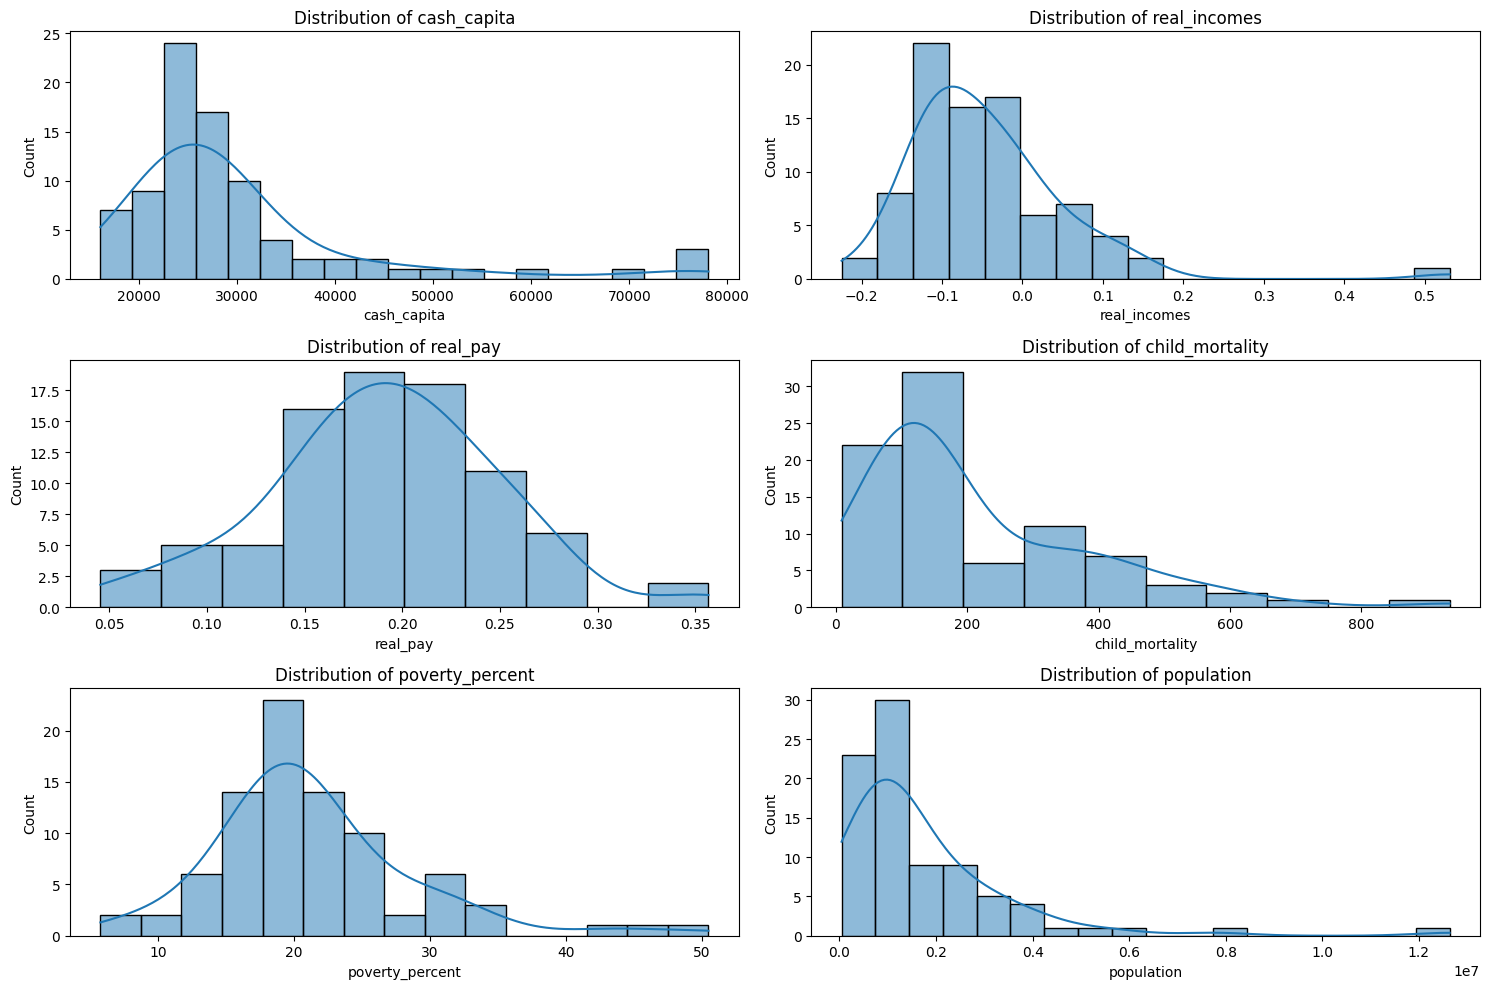

(        cash_capita  real_incomes   real_pay  child_mortality      disabled  \
 count     85.000000     85.000000  85.000000        85.000000  8.500000e+01   
 mean   30100.803922     -0.045308   0.190437       213.530631  1.397616e+06   
 std    12765.987792      0.100841   0.059295       174.125548  1.499477e+06   
 min    16064.166667     -0.224979   0.045487         8.531250  1.719950e+04   
 25%    23330.500000     -0.110725   0.156351        99.781250  6.166945e+05   
 50%    26623.333333     -0.064443   0.189024       145.218750  1.018100e+06   
 75%    30692.500000     -0.008758   0.226087       309.343750  1.835274e+06   
 max    78070.500000      0.531213   0.356740       934.235294  1.073864e+07   
 
              alco      drugs         gross  living_area  \
 count   85.000000  85.000000  8.500000e+01    85.000000   
 mean   114.809305  14.058449  2.624942e+05    17.154118   
 std     61.287074   7.872116  3.226254e+05     2.286167   
 min      0.909091   2.585714  5.70951

In [50]:
df_region = result.copy()

# Summary Statistics
summary_stats = df_region.describe()

# Distribution Analysis for a subset of features
subset_features = ['cash_capita', 'real_incomes', 'real_pay', 'child_mortality', 'poverty_percent', 'population']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(subset_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df_region[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()

summary_stats, plt.show() 

**Сводная статистика**
* cash_capita (Средний ежемесячный доход): Существенно разнится в разных регионах, со средним значением около 30 100 рублей и значительным стандартным отклонением.
* real_incomes (Тенденция реальных доходов): Показывает средний негативный тренд (-4,5%), что указывает на снижение реальных доходов во многих регионах.
* real_pay (Тенденция реальных заработных плат): В среднем показывает положительный тренд (19%), что указывает на увеличение реальных заработных плат, несмотря на снижение реальных доходов.
* child_mortality (Детская смертность): В среднем составляет около 213 на 100 000, но имеет широкий диапазон значений, что указывает на значительные региональные различия.
* poverty_percent (Процент бедности): Средний уровень бедности не указан в сводной информации, но учитывая его важность, его стоит дополнительно изучить.
* population (Население): Показывает широкий диапазон значений, что указывает на смешанный характер регионов с высокой и низкой плотностью населения.

**Анализ распределения**
* cash_capita (Средний ежемесячный доход): Распределение кажется правосторонним, что указывает на то, что большинство регионов имеют более низкий средний доход, с меньшим количеством регионов, имеющих значительно более высокие доходы.
* real_incomes (Тенденция реальных доходов): Распределение слегка левостороннее, что указывает на то, что больше регионов испытывают снижение реальных доходов.
* real_pay (Тенденция реальных заработных плат): Кажется более симметрично распределенным вокруг среднего значения.
* child_mortality (Детская смертность): Показывает распределение, смещенное вправо, что указывает на то, что более высокие уровни детской смертности менее распространены.
poverty_percent (Процент бедности): Важно подробно изучить этот показатель, учитывая акцент на уязвимых группах населения в рамках проекта.

### 2.2. Проверка на наличие выбросов в данных

При анализе распределения данных выявдены выбросы и нам необходимо понять природу выбросов и обработать их, если необходимо

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

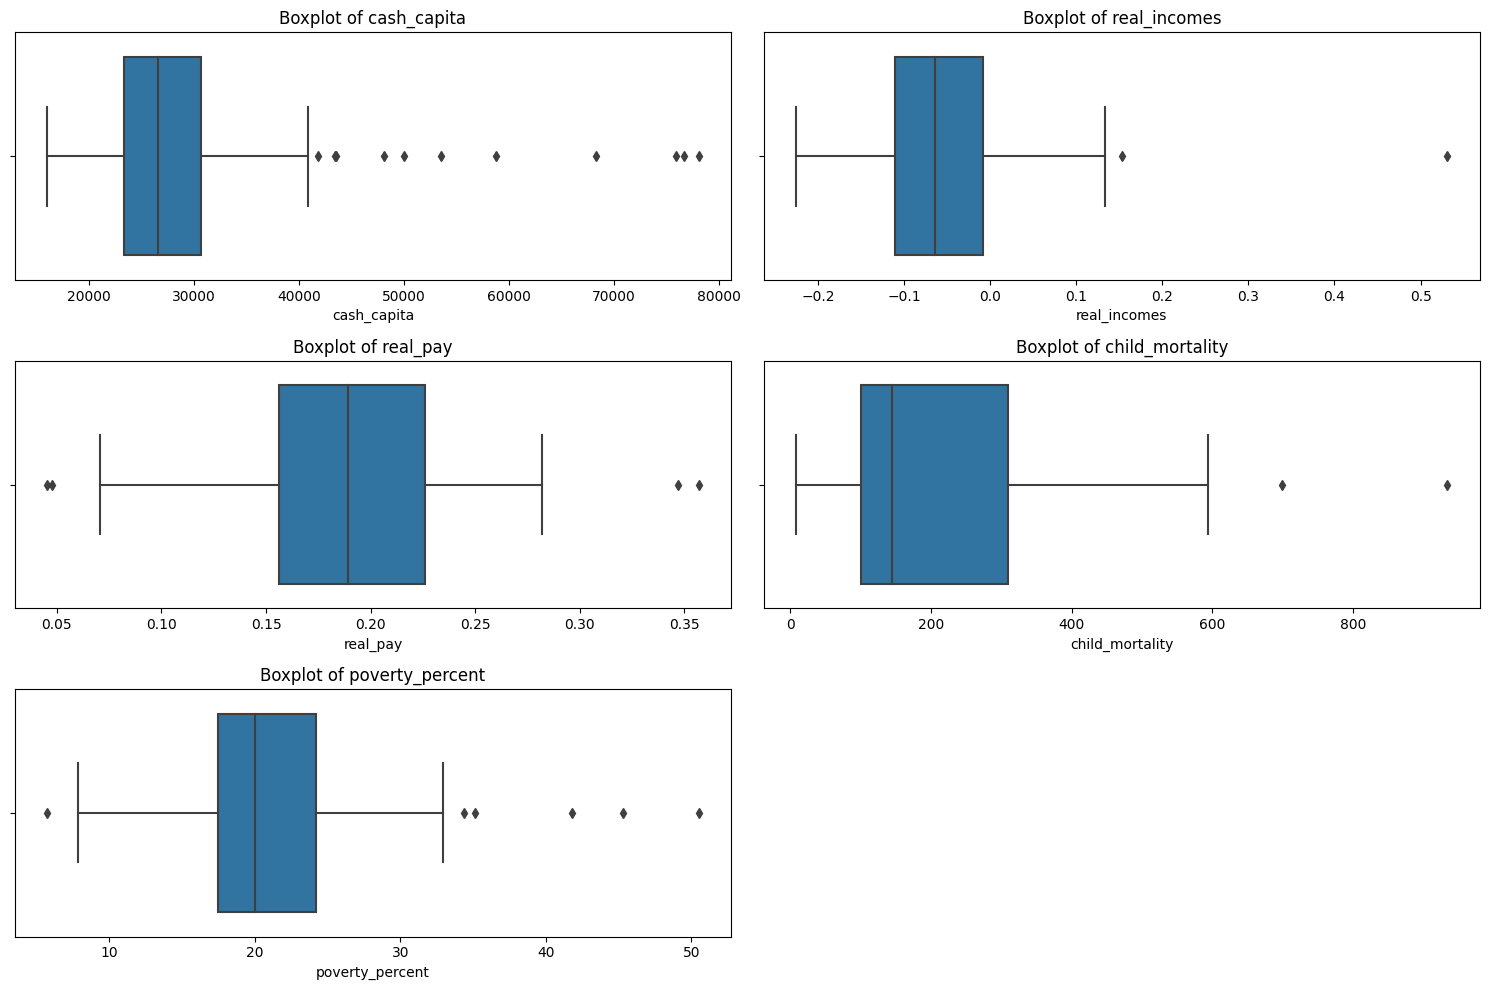

In [51]:
# Plotting box plots for key indicators to visualize outliers
key_indicators_for_outliers = ['cash_capita', 'real_incomes', 'real_pay', 'child_mortality', 'poverty_percent']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(key_indicators_for_outliers, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df_region, x=feature)
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

In [52]:
outliers_info = {}

for feature in key_indicators_for_outliers:
    Q1 = df_region[feature].quantile(0.25)
    Q3 = df_region[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Finding indexes of outliers for each feature
    outlier_indexes = df_region[(df_region[feature] < lower_bound) | (df_region[feature] > upper_bound)].index.tolist()

    # Storing the outlier indexes in the dictionary
    outliers_info[feature] = outlier_indexes

# Displaying the outliers for each key indicator
outliers_info

{'cash_capita': ['Московская область',
  'Москва',
  'Ненецкий автономный округ',
  'Санкт-Петербург',
  'Ханты-Мансийский автономный округ — Югра',
  'Ямало-Ненецкий автономный округ',
  'Республика Саха (Якутия)',
  'Камчатский край',
  'Магаданская область',
  'Сахалинская область',
  'Чукотский автономный округ'],
 'real_incomes': ['Севастополь', 'Ямало-Ненецкий автономный округ'],
 'real_pay': ['Калининградская область',
  'Новгородская область',
  'Республика Дагестан',
  'Республика Алтай'],
 'child_mortality': ['Москва', 'Республика Дагестан'],
 'poverty_percent': ['Республика Калмыкия',
  'Республика Ингушетия',
  'Республика Марий Эл',
  'Ямало-Ненецкий автономный округ',
  'Республика Тыва',
  'Забайкальский край']}

Анализ выявил выбросы в каждом из ключевых показателей:

**cash_capita**
* Среди выбросов находятся регионы с существенно более высокими средними доходами, такие как Москва, Санкт-Петербург и несколько автономных округов (Ненецкий, Ямало-Ненецкий, Чукотский и др.). Эти регионы известны высоким уровнем жизни или специфическими экономическими условиями (например, производством нефти и газа в некоторых автономных округах).

**real_incomes**
* Выбросами являются Севастополь и Ямало-Ненецкий автономный округ, которые показывают значительное увеличение реальных доходов. Эти увеличения могут быть связаны с конкретными региональными экономическими разработками или инвестициями.

**real_pay**
* Среди выбросов есть регионы с очень низкими (Калининград, Новгород) и очень высокими (Республика Дагестан, Республика Алтай) изменениями в реальных заработных платах. Эти различия могут отражать региональные экономические политики или отраслевые факторы.

**child_mortality**
* Москва и Республика Дагестан имеют высокие выбросные значения, что указывает на аномалии данных или серьезные проблемы в области здравоохранения в этих регионах.

**poverty_percent**
* Выбиваются регионы с чрезвычайно высокими уровнями бедности, такие как Республика Калмыкия, Ингушетия и Тыва, а также Ямало-Ненецкий автономный округ с исключительно низким уровнем бедности. Эти неравенства могут отражать различия в региональном экономическом развитии и социальных политиках.

**Вывод**
* Многие из этих выбросов представляют собой регионы с уникальными социально-экономическими условиями, что указывает на то, что они не являются простыми ошибками данных, а отражают реальные региональные различия.
Например, Москва и Санкт-Петербург - это крупные города с более высоким уровнем жизни, в то время как регионы, такие как Республика Тыва и Ингушетия, сталкиваются с более серьезными экономическими вызовами.

### 2.3. Анализ корреляции

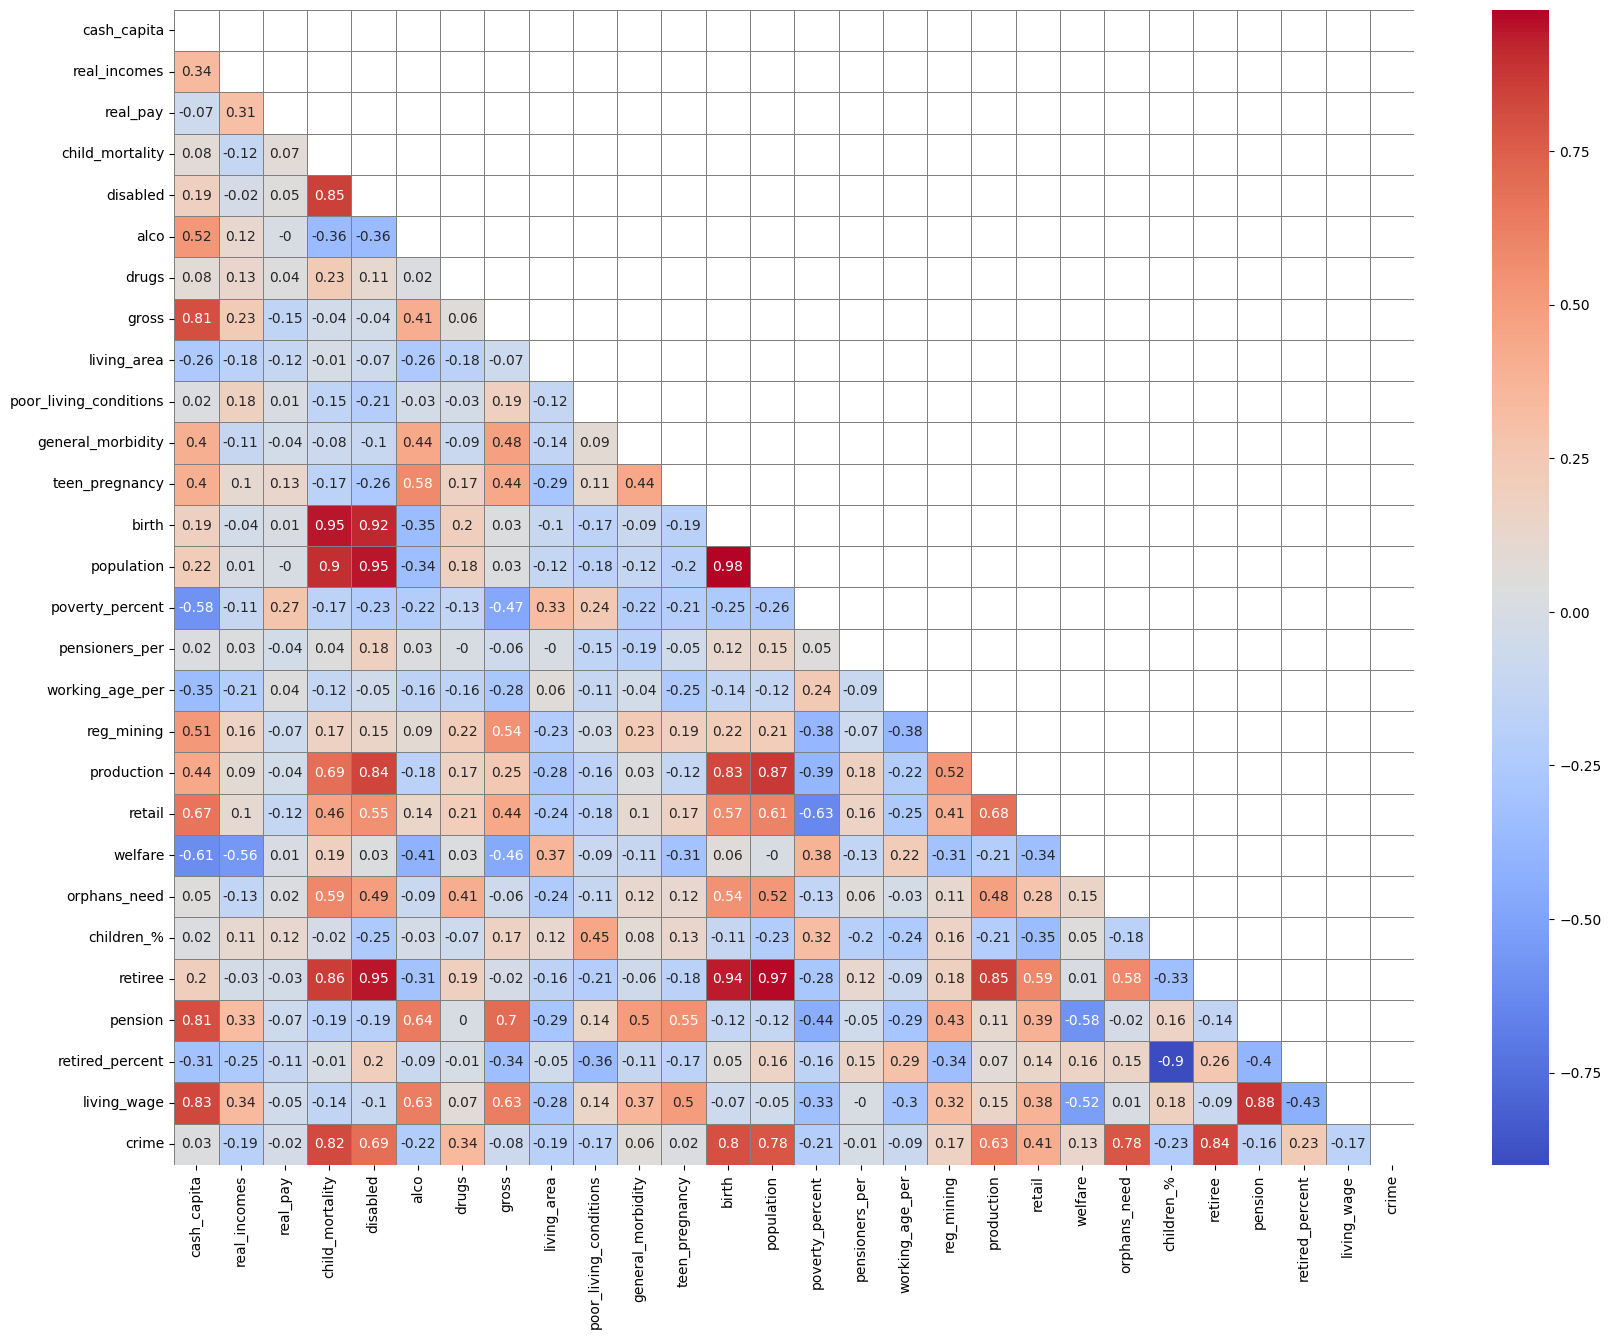

In [53]:
# Создадим тепловую карту, визуализирующую значения матрицы корреляции всех пар переменных
plt.figure(figsize=(20, 15))
corr_matrix = df_region.corr().round(decimals=2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5, mask=mask, linecolor='gray')
plt.show()

Корреляции ключевых признаков:

**poverty_percent**
* Сильная отрицательная корреляция с cash_capita (-0,58): Более высокий средний доход обычно связан с более низкими уровнями бедности.
* Положительная корреляция с real_pay (0,27): Регионы с ростом реальных заработных плат могут иметь более высокий процент бедности, что противоречит интуитивным представлениям и требует дополнительного исследования.
* Отрицательная корреляция с population (-0,26): Большие по численности регионы, как правило, имеют более низкие уровни бедности.

**Средний Ежемесячный Доход (cash_capita)**:
* Положительная корреляция с real_incomes (0,34): По мере увеличения реальных доходов средний доход, как правило, также увеличивается.
* Положительная корреляция с population (0,22): Регионы с более высокой численностью населения могут иметь более высокие средние доходы.

**real_incomes**:
* Положительная корреляция с real_pay (0,31): По мере увеличения реальных заработных плат также обычно увеличиваются и реальные доходы.

**child_mortality**:
* Сильная корреляция с population (0,90): Эта сильная корреляция указывает на то, что регионы с более крупным населением имеют более высокие абсолютные числа детской смертности, но это не обязательно означает более высокую смертность детей.

In [86]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_region)

## 3. Кластеризация

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

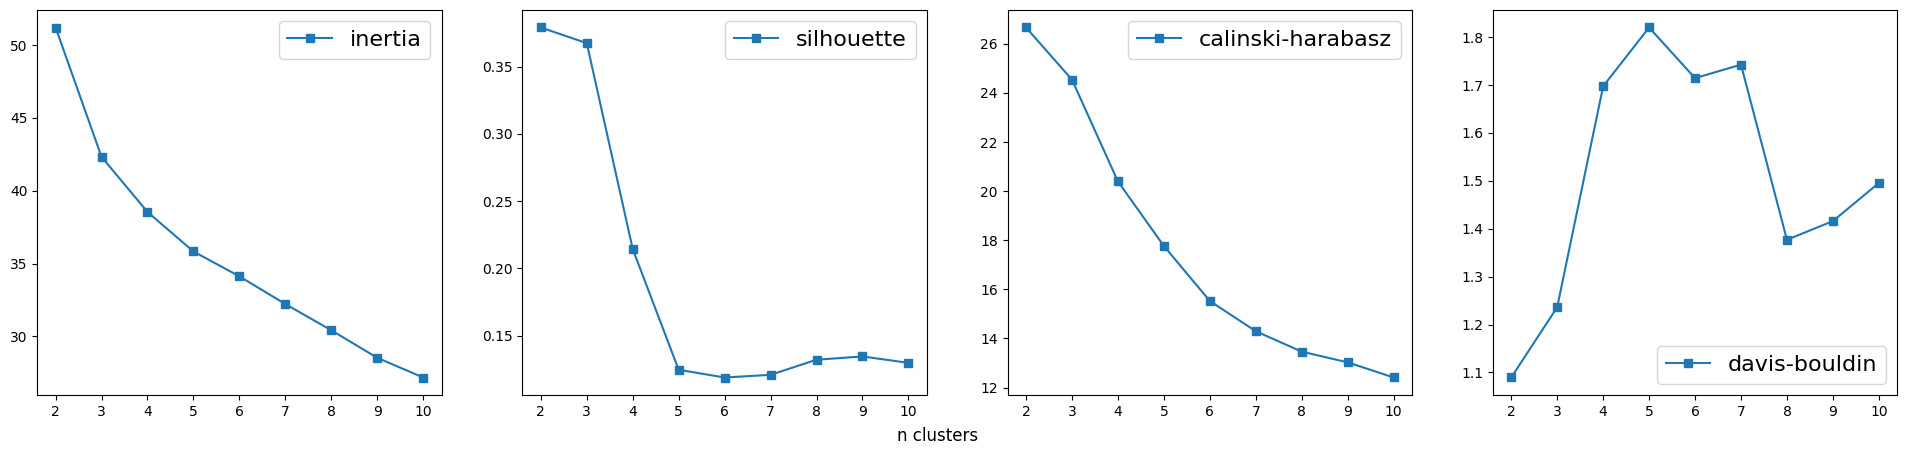

In [87]:
def plot_metrics(X):
    """Построение графиков кластеризации в зависимости от количества кластеров"""
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davis_bouldin = []
    
    for n_cl in range(2, 11):
        kmeans = cluster.KMeans(n_clusters=n_cl, random_state=42)
        kmeans.fit(X)
    
        inertia.append(kmeans.inertia_)
        silhouette.append(metrics.silhouette_score(
            X, kmeans.labels_))
        calinski_harabasz.append(metrics.calinski_harabasz_score(
            X, kmeans.labels_))
        davis_bouldin.append(metrics.davies_bouldin_score(
            X, kmeans.labels_))
        
    fig, ax = plt.subplots(1, 4, figsize=(24,5))
    
    ax[0].plot(range(2, 11), inertia, 's-', label='inertia')
    ax[1].plot(range(2, 11), silhouette, 's-', label='silhouette')
    ax[2].plot(range(2, 11), calinski_harabasz, 's-', label='calinski-harabasz')
    ax[3].plot(range(2, 11), davis_bouldin, 's-', label='davis-bouldin')
    ax[0].legend(prop={'size': 16})
    ax[1].legend(prop={'size': 16})
    ax[2].legend(prop={'size': 16})
    ax[3].legend(prop={'size': 16});
    fig.supxlabel('n clusters')
    
        
plot_metrics(X)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette: 0.125
Calinski-Harabatz: 17.766
Davis-Bouldin: 1.820


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



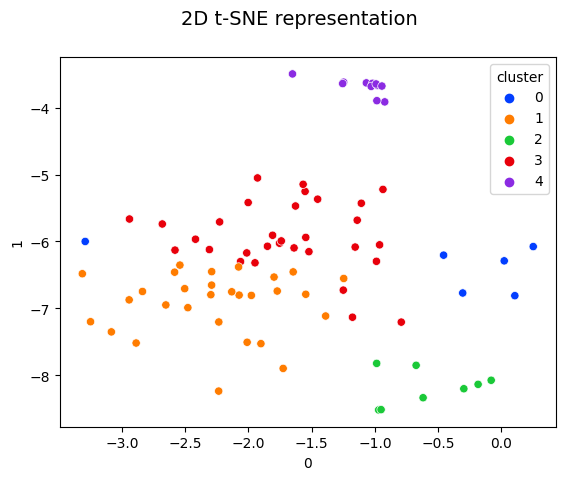

In [89]:
def plot_results(X, labels):
    "Построение 2D t-SNE представление и вычисление метрик"
    tsne = TSNE(n_components=2, perplexity=50, init='pca',
                learning_rate='auto', random_state=42)
    df_tsne = pd.DataFrame(tsne.fit_transform(X))
    df_tsne['cluster'] = labels
    fig = plt.figure()
    sns.scatterplot(x=df_tsne[0], y=df_tsne[1],
                    hue=df_tsne['cluster'], palette='bright')
    fig.suptitle('2D t-SNE representation', fontsize=14);

    print('Silhouette: {:.3f}'.format(
        metrics.silhouette_score(X, labels)))
    print('Calinski-Harabatz: {:.3f}'.format(
        metrics.calinski_harabasz_score(X, labels)))
    print('Davis-Bouldin: {:.3f}'.format(
        metrics.davies_bouldin_score(X, labels)))
        

kmeans = cluster.KMeans(n_clusters=5, random_state=42)
bm_labels = kmeans.fit_predict(X)
plot_results(X, bm_labels)

Число главных компонент: 11


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

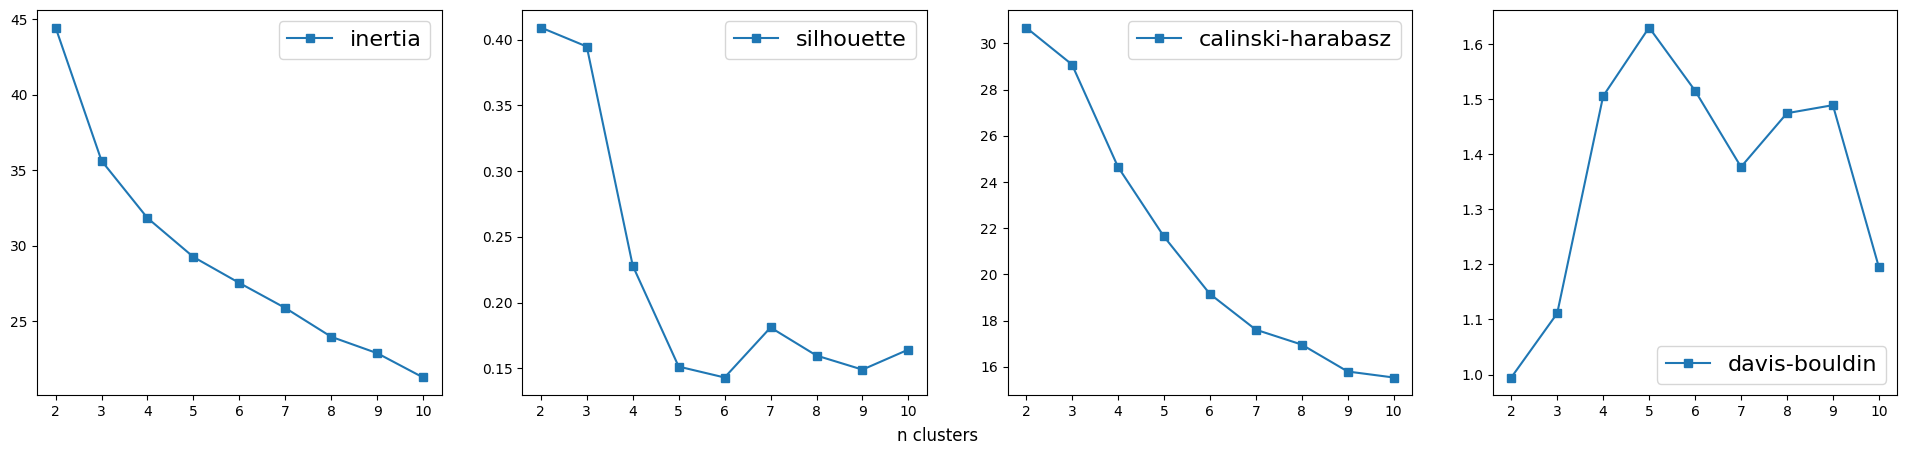

In [90]:
pca = PCA(n_components=0.9)  # 90% of explained dispersion
X_pca = pca.fit_transform(X)
print(f'Число главных компонент: {pca.n_components_}')

plot_metrics(X_pca)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette: 0.151
Calinski-Harabatz: 21.643
Davis-Bouldin: 1.630
Rand score (сравнение с базовой моделью): 0.881513


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



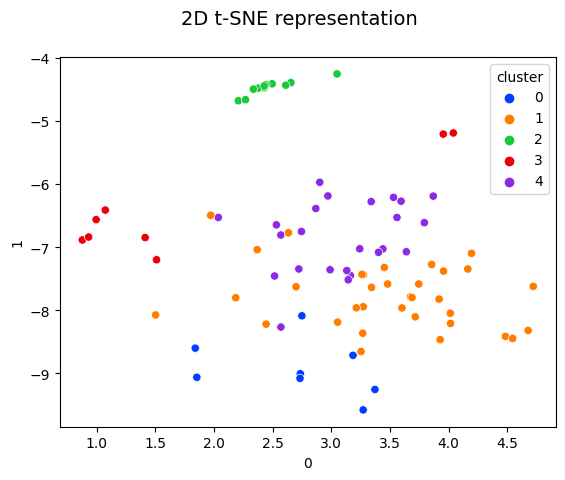

In [91]:
kmeans_pca = cluster.KMeans(n_clusters=5, random_state=42)
kmeans_pca.fit_predict(X_pca)
plot_results(X_pca, kmeans_pca.labels_)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, kmeans_pca.labels_)))

In [92]:
fig = px.scatter_3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    title='Кластеры в пространстве трех главных компонент (PCA)',
    color=kmeans_pca.labels_, width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Silhouette: 0.154
Calinski-Harabatz: 19.240
Davis-Bouldin: 1.673
Rand score (сравнение с базовой моделью): 0.694958


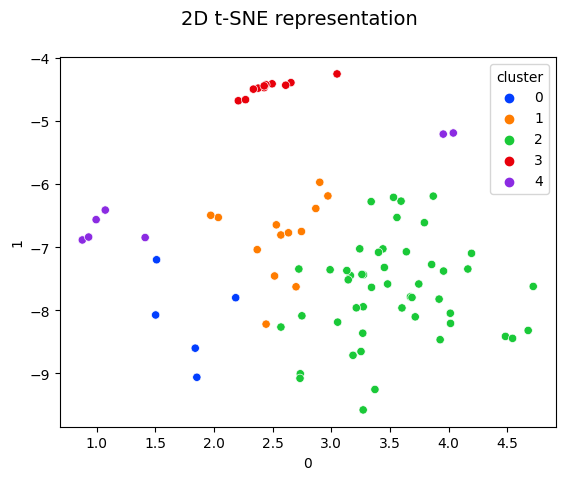

In [95]:
# Гауссова смесь, наилучший вариант: covariance_type='tied'
gmix = GaussianMixture(
    n_components=5, random_state=42, covariance_type='tied')
labels = gmix.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.144
Calinski-Harabatz: 21.239
Davis-Bouldin: 1.645
Rand score (сравнение с базовой моделью): 0.863305


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



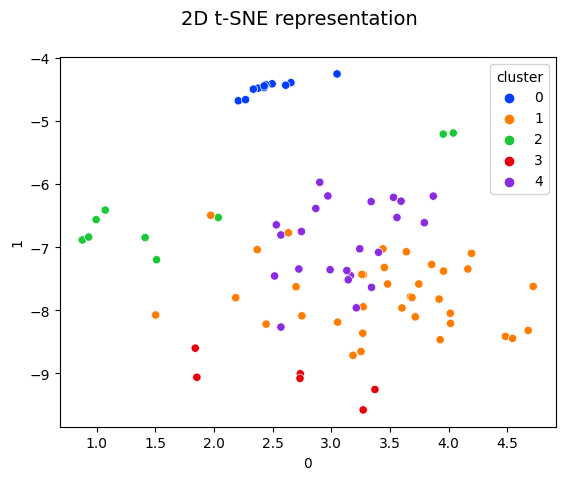

In [96]:
# Агломеративная кластеризация, наилучший вариант: linkage='ward'
tree_like = cluster.AgglomerativeClustering(n_clusters=5, linkage='ward')
labels = tree_like.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.146
Calinski-Harabatz: 15.792
Davis-Bouldin: 1.963
Rand score (сравнение с базовой моделью): 0.693838


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



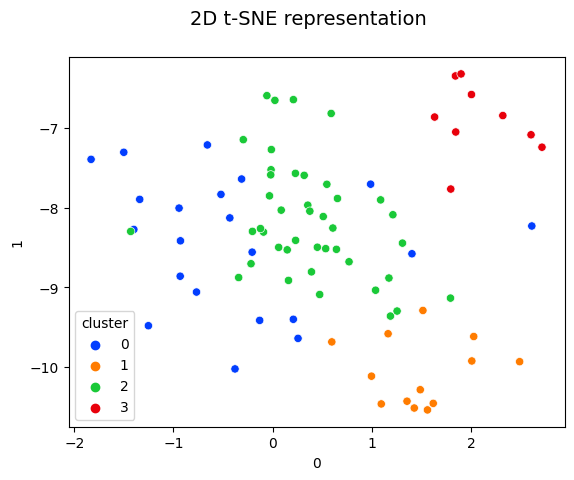

In [84]:
# Метод распространения близости
aff_prop = cluster.AffinityPropagation(damping=0.9, random_state=42)
labels = aff_prop.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.304
Calinski-Harabatz: 17.343
Davis-Bouldin: 1.257
Rand score (сравнение с базовой моделью): 0.804482


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



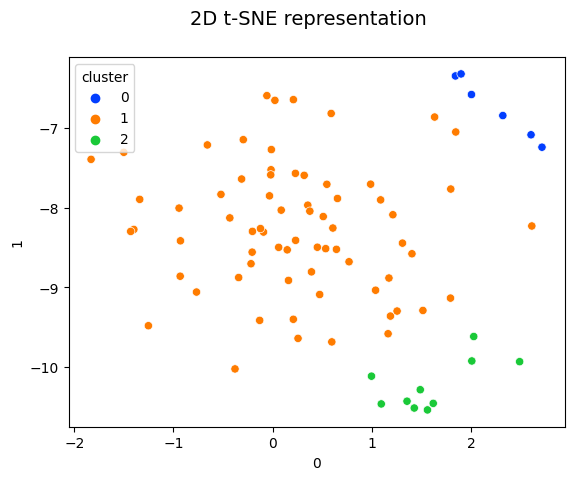

In [85]:
spectral = cluster.SpectralClustering(n_clusters=3)
labels = spectral.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

In [77]:
# Гауссова смесь, наилучший вариант: covariance_type='tied'
gmix = GaussianMixture(
    n_components=3, random_state=42, covariance_type='tied')
labels_gmix = gmix.fit_predict(X_pca)
df_region['cluster'] = labels_gmix

# Упорядочим нумерацию кластеров 
df_region['cluster'] = df_region['cluster'].replace({2:0, 0:1, 3:2, 1:3})
df_region.to_csv('data/regions_cluster.csv')
df_region['cluster'].to_csv('data/labels.csv')

fig = px.scatter_3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    title='Кластеры в пространстве трех главных компонент (PCA)',
    color=df_region['cluster'], width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.show()

In [75]:
df_region[df_region['cluster'] == 3]

,real_incomes,real_pay,disabled,alco,drugs,gross,living_area,poor_living_conditions,general_morbidity,teen_pregnancy,...,working_age_per,reg_mining,production,retail,welfare,orphans_need,children_%,living_wage,crime,cluster
region,,,,,,,,,,,,,,,,,,,,,
Московская область,0.021426,0.127845,4.433168e+06,76.971429,16.364286,255299.896,14.8,0.5,70404.35,815.500000,...,44.4,1.396339e+07,3.219545e+09,289690.333333,18.433333,1155.875,18.755726,13169.0,23044.397436,3
Москва,0.047644,0.236050,1.073864e+07,47.450000,14.014286,666775.680,13.8,0.2,63887.45,29.900000,...,48.5,1.483557e+09,1.041149e+10,381303.222222,16.983333,1751.125,16.362466,17740.0,21935.666667,3
Санкт-Петербург,0.102459,0.256044,6.107657e+06,40.742857,17.571429,355494.408,15.7,0.1,97324.25,519.633333,...,64.6,2.930668e+07,2.807952e+09,251650.222222,15.733333,1495.250,16.383031,11910.0,11120.384615,3
Свердловская область,-0.116535,0.143581,2.887300e+06,96.707143,28.600000,240022.084,15.8,0.5,74009.70,1127.633333,...,51.5,8.218215e+07,2.099712e+09,252215.000000,21.150000,2078.250,20.841716,10817.0,21953.871795,3
Челябинская область,-0.120041,0.096685,2.332220e+06,114.207143,27.014286,189387.968,16.0,0.5,87331.70,1530.566667,...,53.4,9.312916e+07,1.260123e+09,156456.777778,21.683333,2361.625,20.917171,11232.0,22544.371795,3
Красноярский край,0.000597,0.245729,1.893378e+06,133.192857,22.307143,337849.376,16.6,0.8,78460.95,1497.066667,...,59.4,6.791924e+08,1.685322e+09,184501.888889,20.366667,2106.625,21.387846,13053.0,17580.410256,3
Иркутская область,-0.021181,0.193652,2.213284e+06,160.914286,28.678571,237599.412,16.3,0.9,97599.60,1006.000000,...,51.5,5.529576e+08,3.221801e+08,142186.333333,22.983333,2232.125,23.546939,11982.0,15168.923077,3
Кемеровская область — Кузбасс,-0.082972,0.249468,2.322802e+06,87.850000,32.192857,188432.100,16.3,0.1,86666.60,1866.500000,...,55.8,9.166550e+08,7.701587e+08,139066.444444,21.550000,2096.875,21.273003,10403.0,20121.858974,3
Забайкальский край,-0.040945,0.222659,8.312530e+05,122.050000,7.757143,141752.932,17.1,0.9,67719.95,1664.300000,...,59.3,1.242679e+08,-7.852027e+08,148510.666667,22.966667,1425.625,24.840791,12999.0,9943.961538,3
